In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
import random

from sklearn.preprocessing import LabelEncoder
import umap
from umap.umap_ import nearest_neighbors
from sklearn.preprocessing import StandardScaler

from utils import plotting

In [2]:
# For plotting
sns.set_theme(style="ticks", font_scale=1.4)
DOT_SIZE = 10
ALPHA = .5

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
# List of titles for plots of PAFs
feature_titles_list = [
    "Duration [s]",
    "Temporal 1st Quartile [s]", 
    "Temporal Median [s]", 
    "Temporal 3rd Quartile [s]", 
    "Temporal Standard Deviation [s]", 
    "Temporal Skewness", 
    "Temporal Kurtosis", 
    "Temporal Entropy", 
    "Mean Frequency [kHz]",
    "Mean Peak Frequency [kHz]",
    "Spectral Sandard Deviation [kHz]",
    "Spectral Flatness", 
    "Frequency 1st Quartile [kHz]",
    "Frequency Median [kHz]", 
    "Frequency 3rd Quartile [kHz]", 
    "Mean Dominant Frequency [kHz]", 
    "Min Dominant Frequency [kHz]",
    "Max Dominant Frequency [kHz]", 
    "Dominant Frequency Range [kHz]", 
    "Dominant Frequency Modulation [kHz]", 
    "Spectral Entropy", 
    "Harmonics-to-Noise Ratio [dB]",
    "Spectrographic Entropy"
    ]

# List of column names of PAFs
feature_columns_list = [
    "duration",
    "t_q1", 
    "t_median", 
    "t_q3", 
    "std_t", 
    "skew_t", 
    "kurt_t", 
    "t_entropy", 
    "mean_f",
    "mean_peak_f", 
    "std_f",
    "flatness_s", 
    "f_q1",
    "f_median", 
    "f_q3", 
    "mean_dom", 
    "min_dom",
    "max_dom", 
    "range_dom", 
    "mod_dom", 
    "pse", 
    "hnr",
    "spectrographic_entropy"
    ]

In [5]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_log_freq_spectrogram'] = calls_df['log_padded_log_freq_spectrogram'].apply(lambda x: np.array(json.loads(x)))
calls_df['log_padded_lfccs'] = calls_df['log_padded_lfccs'].apply(lambda x: np.asarray(json.loads(x)))
calls_df['log_padded_mfccs'] = calls_df['log_padded_mfccs'].apply(lambda x: np.asarray(json.loads(x)))

In [6]:
# import latent representations from VAE and merge with calls df
representations_df = pd.read_csv("pickles_and_csvs/latent_representations_CVAE_adam.csv")
representations_df["latent_representation"] = representations_df["latent_representation"].apply(lambda x: np.asarray(json.loads(x)))
calls_df = pd.merge(calls_df, representations_df, on="clip_ID")
calls_df = calls_df.drop(columns=["call_type_y"])
calls_df = calls_df.rename(columns={"call_type_x": "call_type"})

In [7]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   track_ID                         7043 non-null   object 
 1   clip_ID                          7043 non-null   object 
 2   goose_ID                         7043 non-null   object 
 3   call_type                        7043 non-null   object 
 4   waveform                         7043 non-null   object 
 5   sr                               7043 non-null   int64  
 6   filepath                         7043 non-null   object 
 7   log_scaled_spectrogram           7043 non-null   object 
 8   lfccs                            7043 non-null   object 
 9   mfccs                            7043 non-null   object 
 10  peak                             7043 non-null   float64
 11  duration                         7043 non-null   float64
 12  log_padded_spectro

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_8581/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

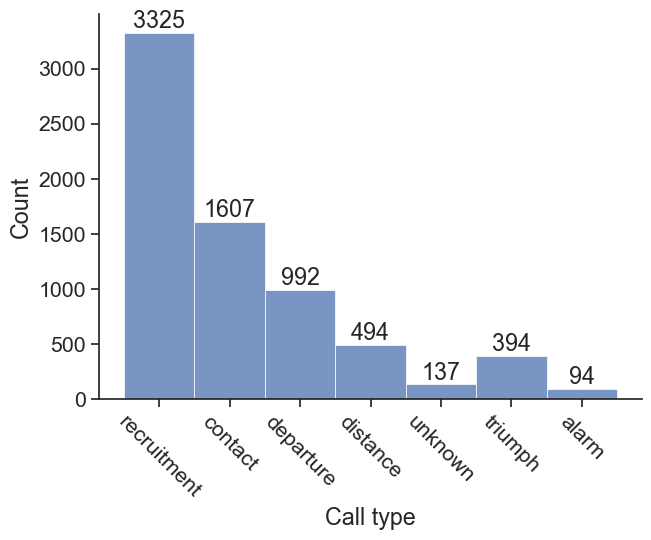

In [8]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

In [9]:
def create_representations_subdf_and_scale(full_df, column_name, column_names=["call_type", "track_ID", "goose_ID"]):
    column_names_new_df = column_names.copy()
    subset_list = []
    for idx, row in full_df.iterrows():
        subset_list.append([row["call_type"], row["track_ID"], row["goose_ID"], *row[column_name].flatten()])

    for i in range(len(full_df.iloc[0][column_name].flatten())):
        column_names_new_df.append(i)

    subset_df = pd.DataFrame(subset_list, columns=column_names_new_df, index=None)
    subset_df.head()

    subset_scaled = StandardScaler().fit_transform(subset_df.drop(columns=column_names))

    return subset_scaled, subset_df

In [10]:
NEIGHBORS_RATIO = .2
DISTANCE_METRIC = "euclidean"

In [11]:
n_neighbors = int(len(calls_df) * NEIGHBORS_RATIO)

# Encode call type
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

# Load representation dataframes
paf_scaled = StandardScaler().fit_transform(calls_df.drop(columns=[col for col in calls_df.columns if col not in feature_columns_list])) #["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_scaled_spectrogram", "log_padded_spectrogram", "log_padded_lfccs", "log_padded_log_freq_spectrogram", "lfccs", "log_padded_lfccs", "latent_representation", "duration_paf"]
lfccs_scaled, lfccs_df = create_representations_subdf_and_scale(calls_df, "log_padded_lfccs")
spectrograms_scaled, spectrograms_df = create_representations_subdf_and_scale(calls_df, "log_padded_spectrogram")
_, vae_df = create_representations_subdf_and_scale(calls_df, "latent_representation")

# NN Graphs
nn_results_paf = nearest_neighbors(paf_scaled, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_lfcc = nearest_neighbors(lfccs_scaled, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_spec = nearest_neighbors(spectrograms_scaled, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_vae = nearest_neighbors(vae_df.drop(columns=["call_type", "track_ID", "goose_ID"]), n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)

# Reduce dimensionality
embeddings_paf = umap.UMAP(precomputed_knn=nn_results_paf, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(paf_scaled)
embeddings_lfcc = umap.UMAP(precomputed_knn=nn_results_lfcc, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(lfccs_scaled)
embeddings_spec = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(spectrograms_scaled)
embeddings_vae = umap.UMAP(precomputed_knn=nn_results_vae, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(vae_df.drop(columns=["call_type", "track_ID", "goose_ID"]))

In [12]:
def plot_all(subset_df, embeddings_paf, embeddings_lfcc, embeddings_spec, embeddings_vae):
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "call_type", "UMAP embeddings of PAF", "Call Type")
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "call_type", "UMAP embeddings of LFCC", "Call Type")
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "call_type", "UMAP embeddings of spectrograms", "Call Type")
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "call_type", "UMAP embeddings of VAE representations", "Call Type")

    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "goose_ID", "UMAP embeddings of PAF - Goose ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "goose_ID", "UMAP embeddings of LFCC - Goose ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "goose_ID", "UMAP embeddings of spectrograms - Goose ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "goose_ID", "UMAP embeddings of VAE representations - Goose ID", show_legend=False)

    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_paf, "track_ID", "UMAP embeddings of PAF - Track ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_lfcc, "track_ID", "UMAP embeddings of LFCC - Track ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_spec, "track_ID", "UMAP embeddings of spectrograms - Track ID", show_legend=False)
    plotting.plot_embeddings_with_colorcoded_label(subset_df, embeddings_vae, "track_ID", "UMAP embeddings of VAE representations - Track ID", show_legend=False)


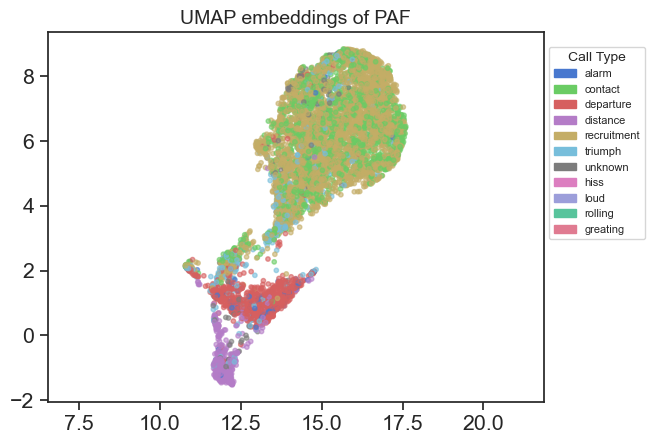

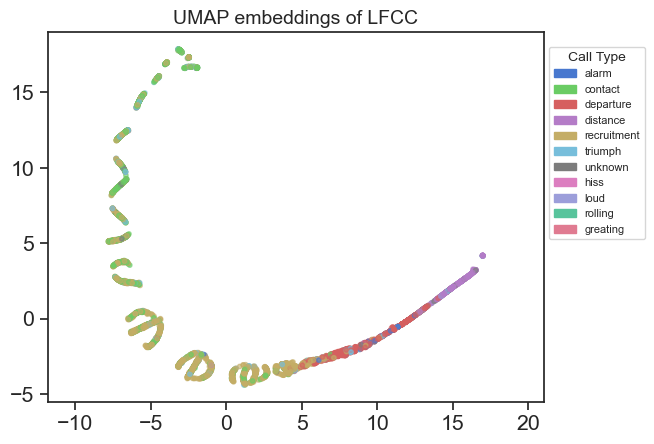

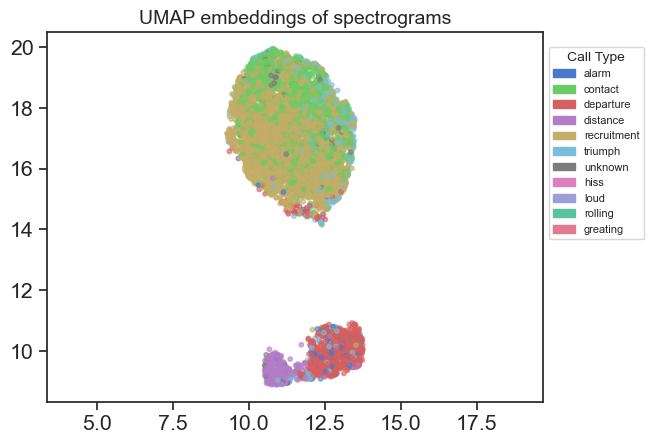

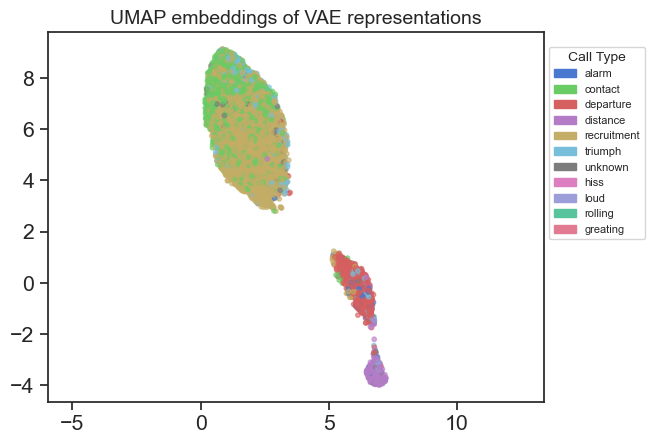

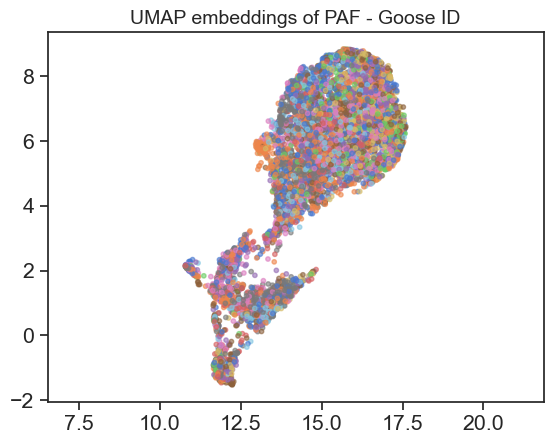

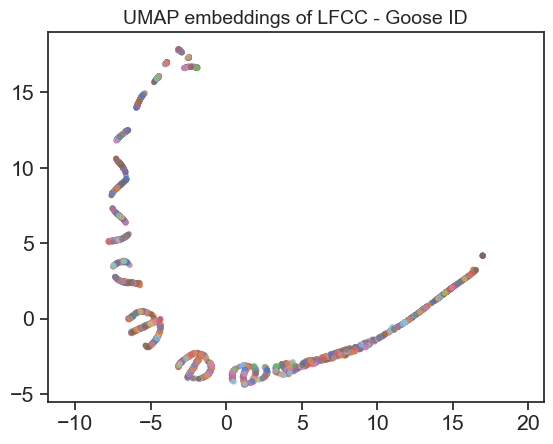

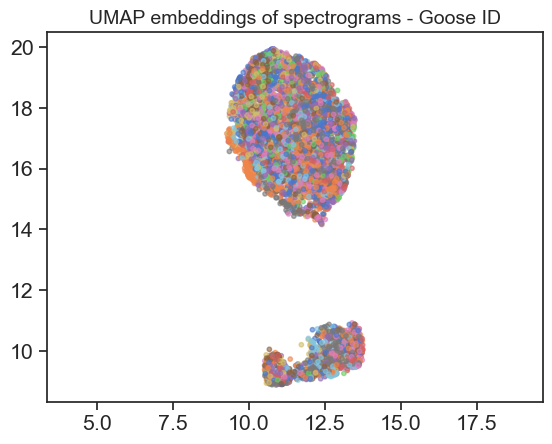

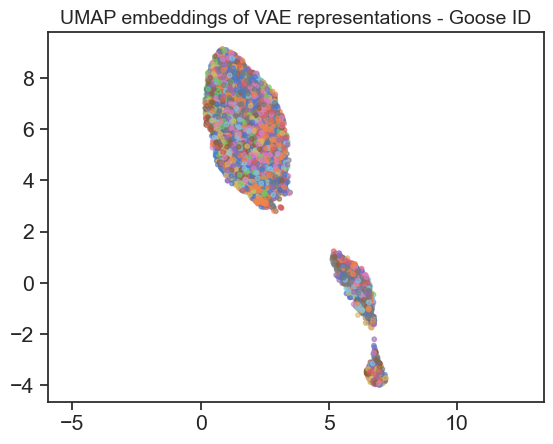

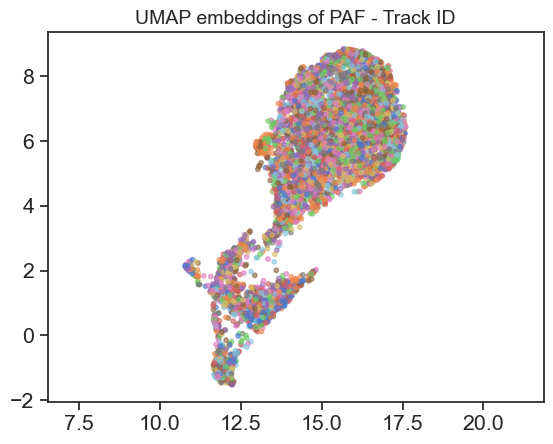

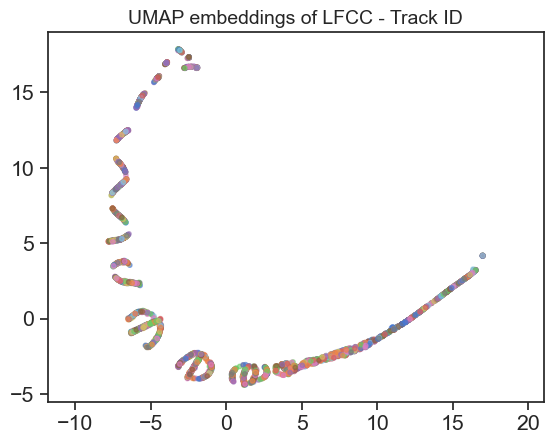

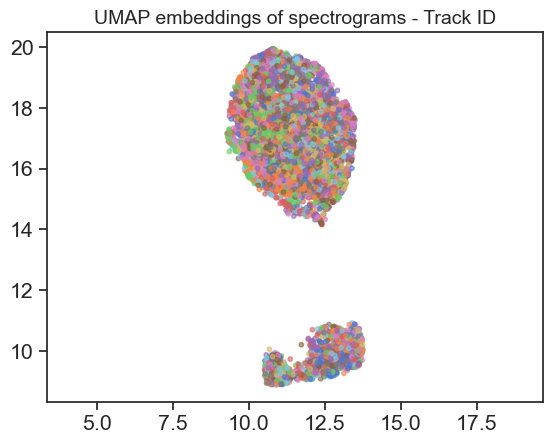

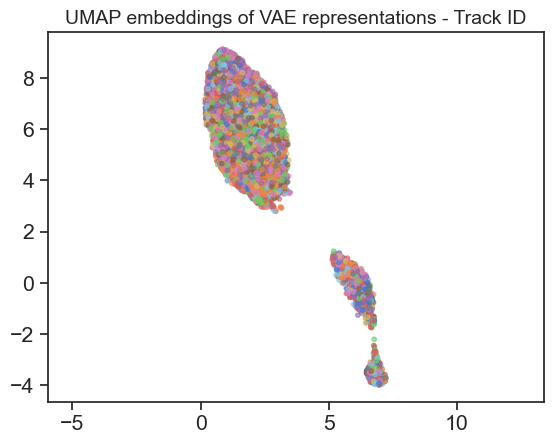

In [15]:
plot_all(calls_df, embeddings_paf, embeddings_lfcc, embeddings_spec, embeddings_vae)

In [17]:
umap_df = pd.DataFrame(embeddings_spec, columns=["dim_1", "dim_2"])

In [ ]:
filtered_calls_df_contact_rec = calls_df[umap_df["dim_2"] > 13]
embeddings_spec_filtered = embeddings_spec[umap_df["dim_2"] > 13]
plotting.plot_embeddings_with_colorcoded_label(filtered_calls_df_contact_rec, embeddings_spec_filtered, "call_type", "UMAP embeddings of spectrograms", "Call Type")

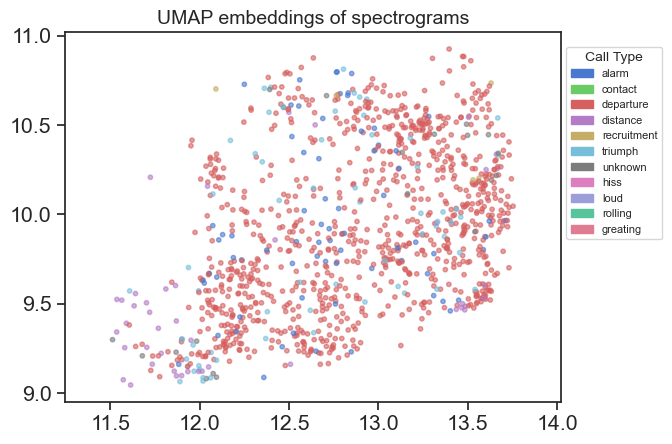

In [32]:
filtered_calls_df_dep = calls_df[(umap_df["dim_2"] < 13) & (umap_df["dim_1"] > 11.5)]
embeddings_spec_filtered_dep = embeddings_spec[(umap_df["dim_2"] < 13) & (umap_df["dim_1"] > 11.5)]
plotting.plot_embeddings_with_colorcoded_label(filtered_calls_df_dep, embeddings_spec_filtered_dep, "call_type", "UMAP embeddings of spectrograms", "Call Type")

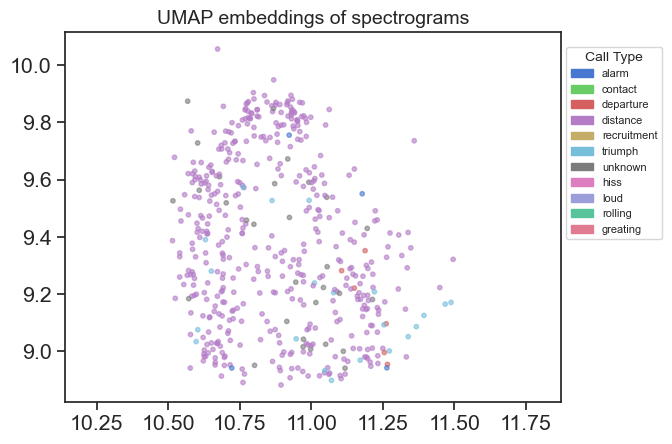

In [33]:
filtered_calls_df_dist = calls_df[(umap_df["dim_2"] < 13) & (umap_df["dim_1"] < 11.5)]
embeddings_spec_filtered_dist = embeddings_spec[(umap_df["dim_2"] < 13) & (umap_df["dim_1"] < 11.5)]
plotting.plot_embeddings_with_colorcoded_label(filtered_calls_df_dist, embeddings_spec_filtered_dist, "call_type", "UMAP embeddings of spectrograms", "Call Type")

## embed calls agin 

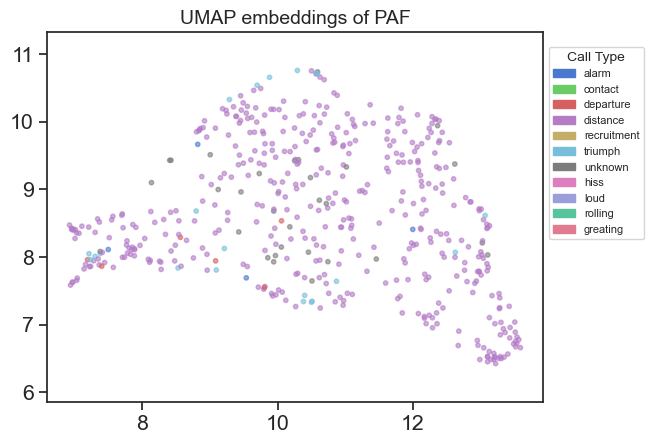

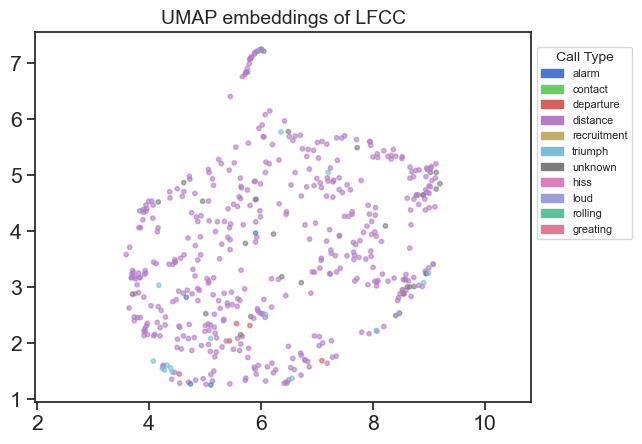

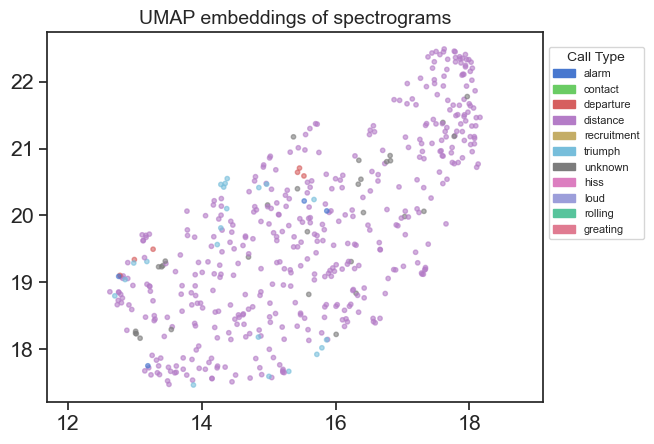

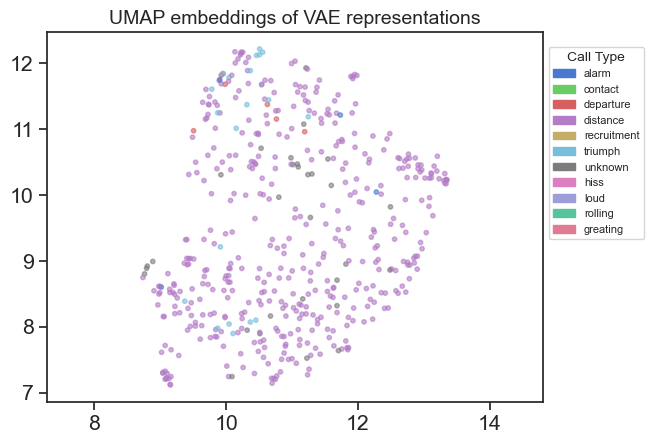

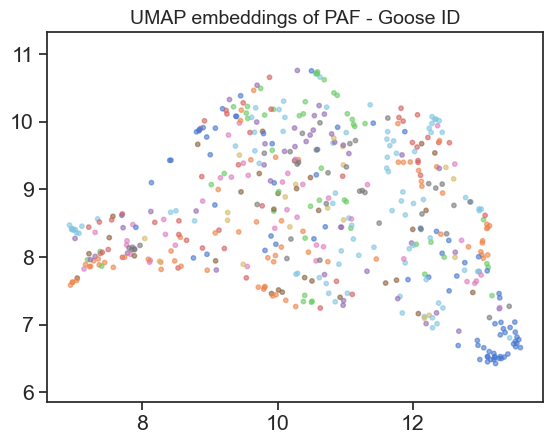

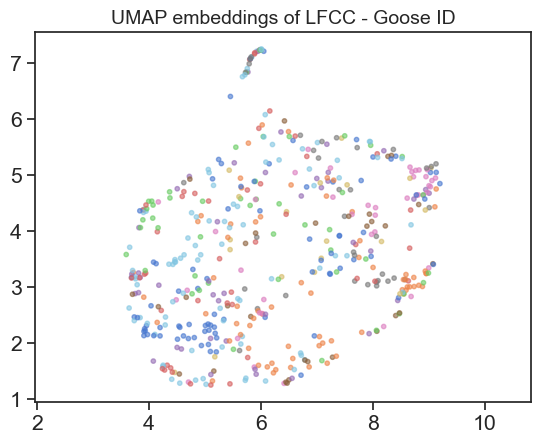

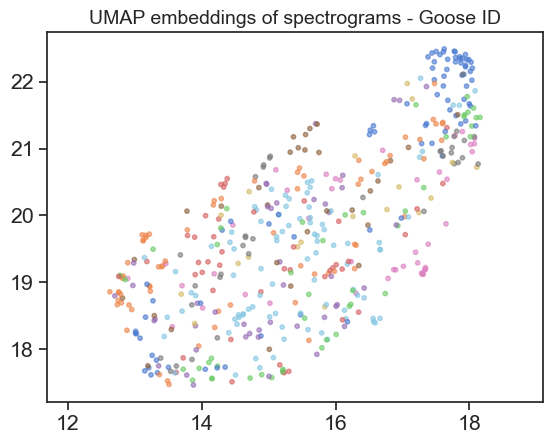

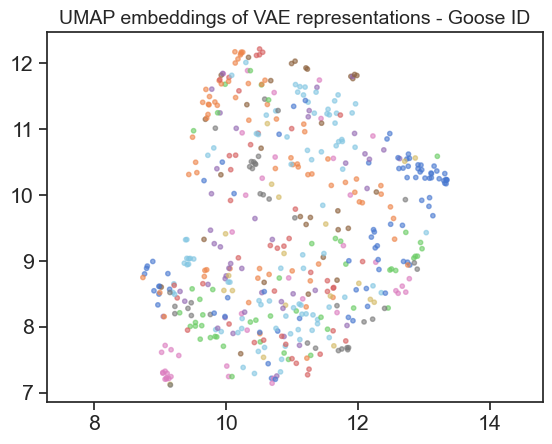

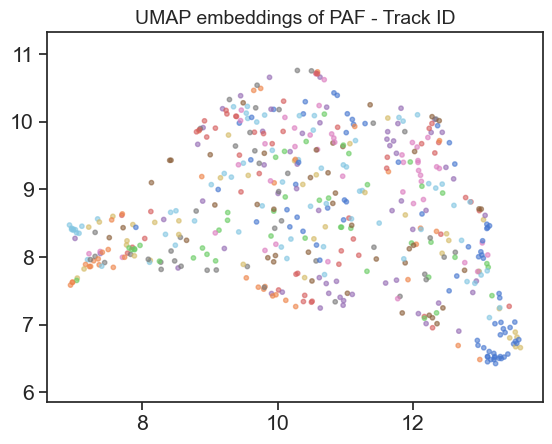

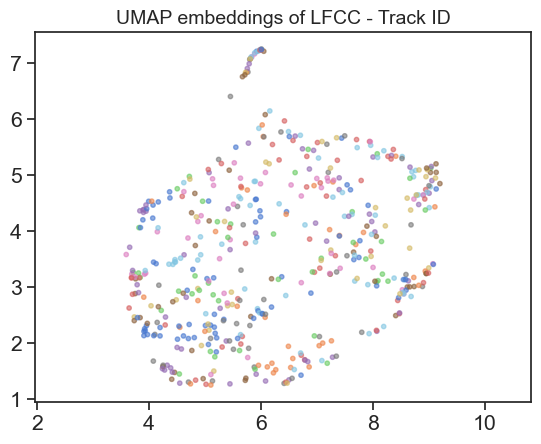

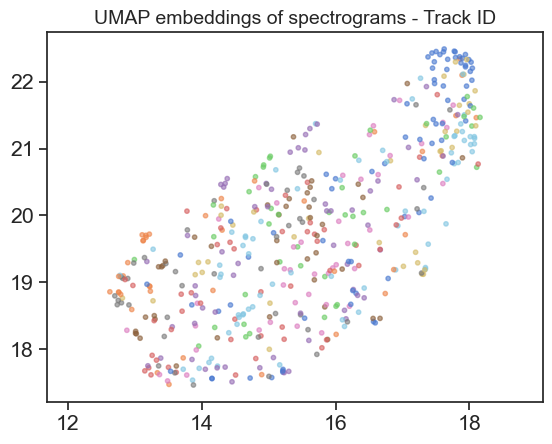

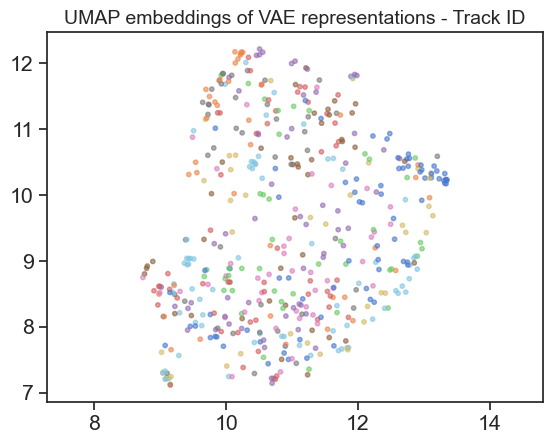

In [34]:
n_neighbors = int(len(filtered_calls_df_dist) * NEIGHBORS_RATIO)

# Load representation dataframes
paf_scaled_dist = StandardScaler().fit_transform(filtered_calls_df_dist.drop(columns=[col for col in filtered_calls_df_dist.columns if col not in feature_columns_list])) #["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_scaled_spectrogram", "log_padded_spectrogram", "log_padded_lfccs", "log_padded_log_freq_spectrogram", "lfccs", "log_padded_lfccs", "latent_representation", "duration_paf"]
lfccs_scaled_dist, lfccs_df_dist = create_representations_subdf_and_scale(filtered_calls_df_dist, "log_padded_lfccs")
spectrograms_scaled_dist, spectrograms_df_dist = create_representations_subdf_and_scale(filtered_calls_df_dist, "log_padded_spectrogram")
_, vae_df_dist = create_representations_subdf_and_scale(filtered_calls_df_dist, "latent_representation")

# NN Graphs
nn_results_paf_dist = nearest_neighbors(paf_scaled_dist, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_lfcc_dist = nearest_neighbors(lfccs_scaled_dist, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_spec_dist = nearest_neighbors(spectrograms_scaled_dist, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_vae_dist = nearest_neighbors(vae_df_dist.drop(columns=["call_type", "track_ID", "goose_ID"]), n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)

# Reduce dimensionality
embeddings_paf_dist = umap.UMAP(precomputed_knn=nn_results_paf_dist, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(paf_scaled_dist)
embeddings_lfcc_dist = umap.UMAP(precomputed_knn=nn_results_lfcc_dist, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(lfccs_scaled_dist)
embeddings_spec_dist = umap.UMAP(precomputed_knn=nn_results_spec_dist, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(spectrograms_scaled_dist)
embeddings_vae_dist = umap.UMAP(precomputed_knn=nn_results_vae_dist, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(vae_df_dist.drop(columns=["call_type", "track_ID", "goose_ID"]))

plot_all(filtered_calls_df_dist, embeddings_paf_dist, embeddings_lfcc_dist, embeddings_spec_dist, embeddings_vae_dist)

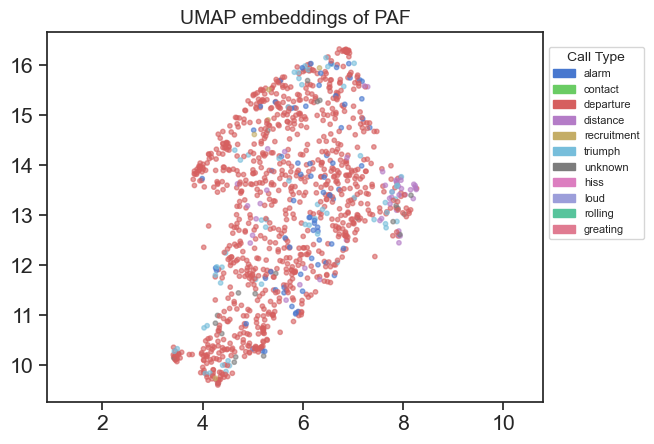

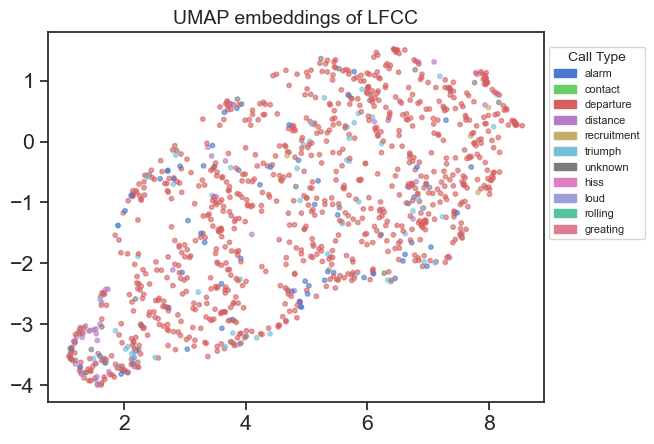

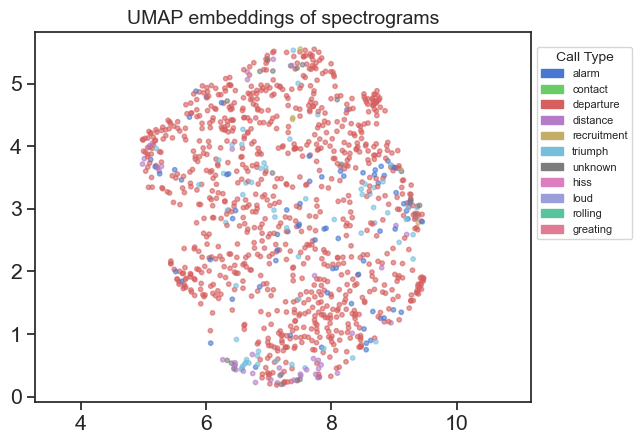

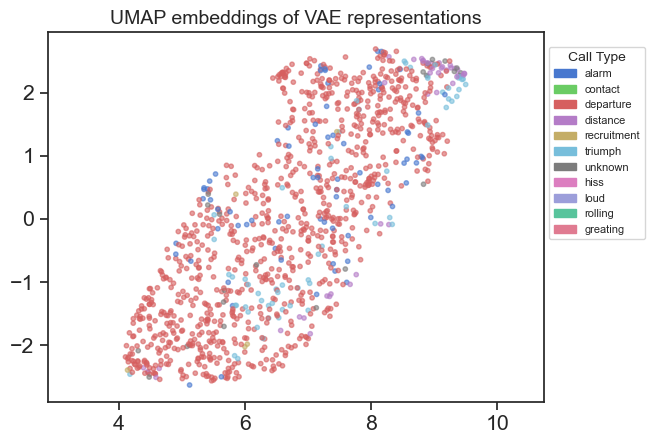

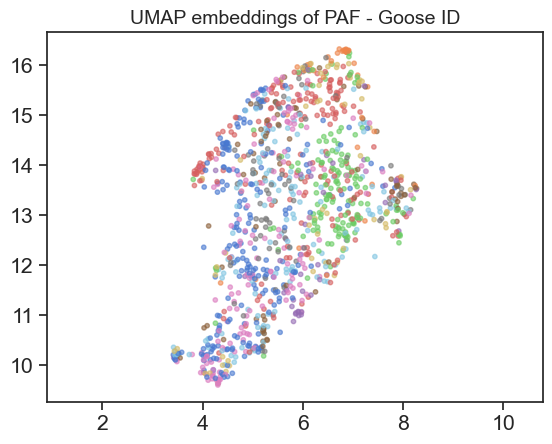

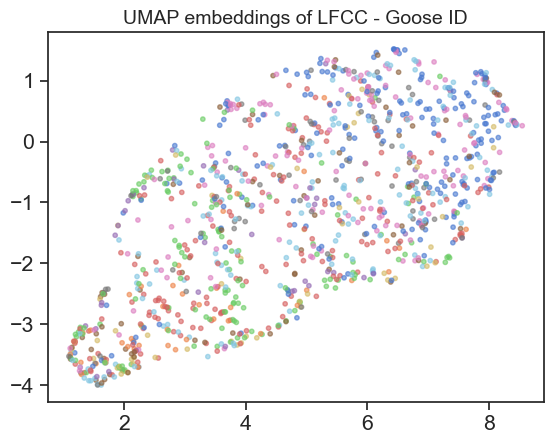

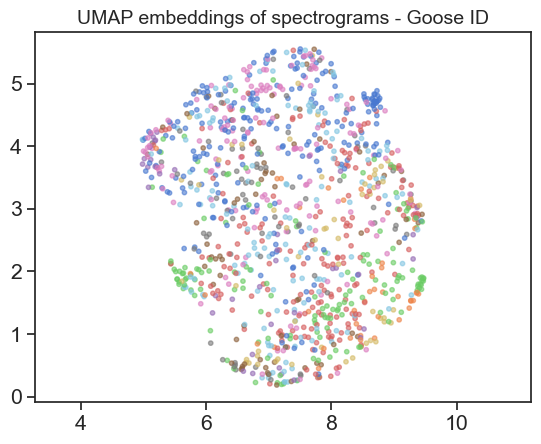

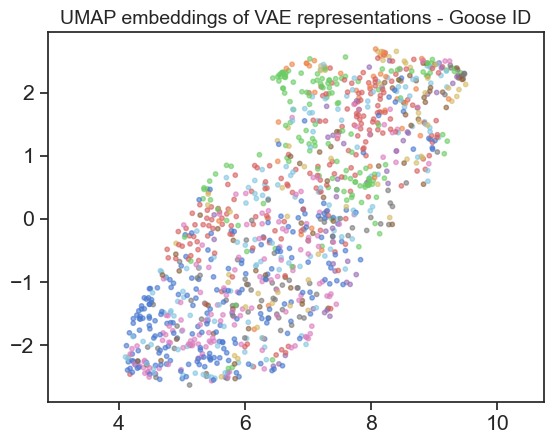

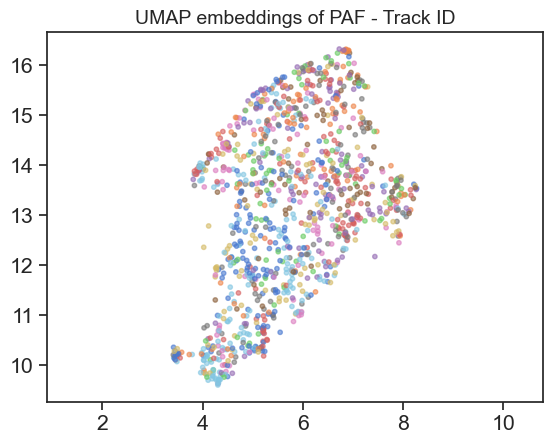

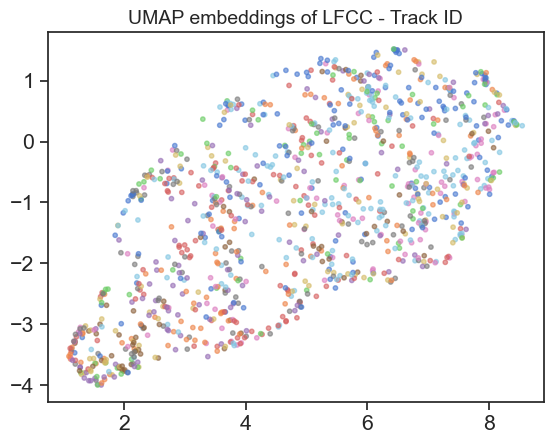

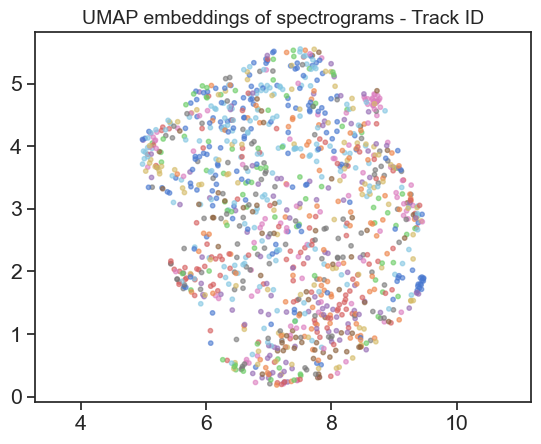

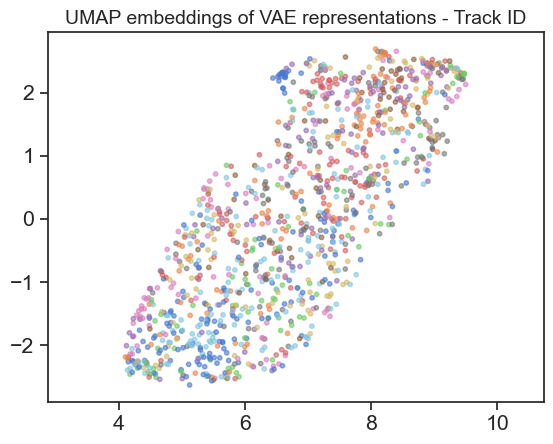

In [36]:
n_neighbors = int(len(filtered_calls_df_dep) * NEIGHBORS_RATIO)

# Load representation dataframes
paf_scaled_dep = StandardScaler().fit_transform(filtered_calls_df_dep.drop(columns=[col for col in filtered_calls_df_dep.columns if col not in feature_columns_list])) #["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_scaled_spectrogram", "log_padded_spectrogram", "log_padded_lfccs", "log_padded_log_freq_spectrogram", "lfccs", "log_padded_lfccs", "latent_representation", "duration_paf"]
lfccs_scaled_dep, lfccs_df_dep = create_representations_subdf_and_scale(filtered_calls_df_dep, "log_padded_lfccs")
spectrograms_scaled_dep, spectrograms_df_dep = create_representations_subdf_and_scale(filtered_calls_df_dep, "log_padded_spectrogram")
_, vae_df_dep = create_representations_subdf_and_scale(filtered_calls_df_dep, "latent_representation")

# NN Graphs
nn_results_paf_dep = nearest_neighbors(paf_scaled_dep, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_lfcc_dep = nearest_neighbors(lfccs_scaled_dep, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_spec_dep = nearest_neighbors(spectrograms_scaled_dep, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_vae_dep = nearest_neighbors(vae_df_dep.drop(columns=["call_type", "track_ID", "goose_ID"]), n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)

# Reduce dimensionality
embeddings_paf_dep = umap.UMAP(precomputed_knn=nn_results_paf_dep, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(paf_scaled_dep)
embeddings_lfcc_dep = umap.UMAP(precomputed_knn=nn_results_lfcc_dep, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(lfccs_scaled_dep)
embeddings_spec_dep = umap.UMAP(precomputed_knn=nn_results_spec_dep, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(spectrograms_scaled_dep)
embeddings_vae_dep = umap.UMAP(precomputed_knn=nn_results_vae_dep, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(vae_df_dep.drop(columns=["call_type", "track_ID", "goose_ID"]))

plot_all(filtered_calls_df_dep, embeddings_paf_dep, embeddings_lfcc_dep, embeddings_spec_dep, embeddings_vae_dep)

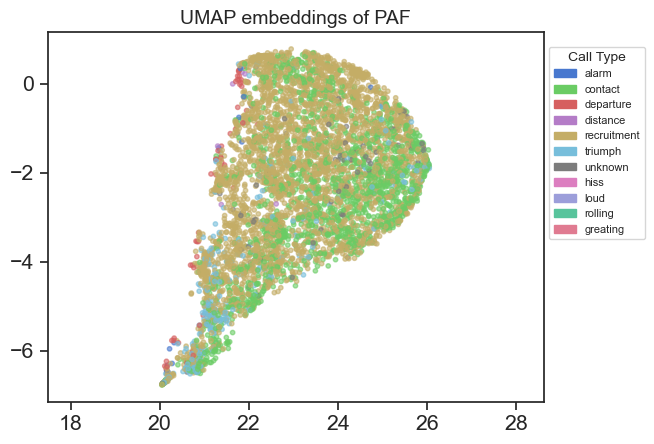

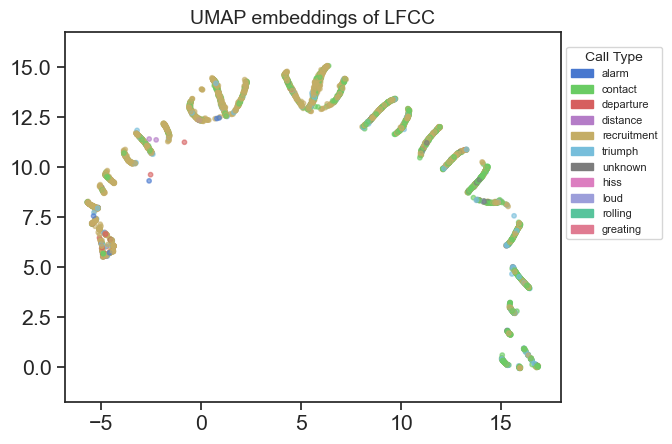

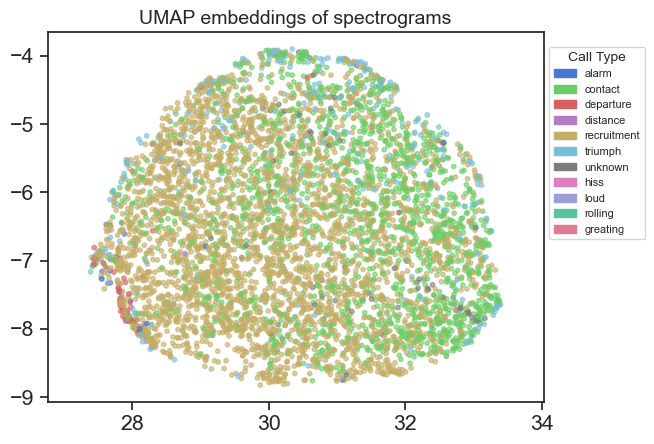

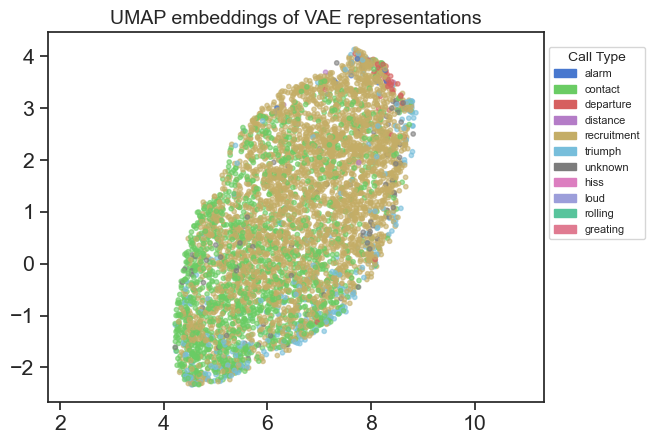

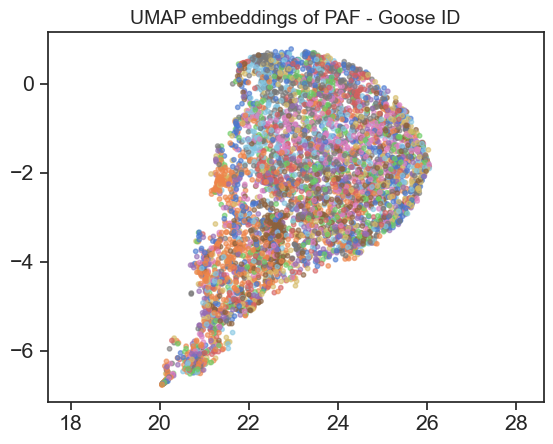

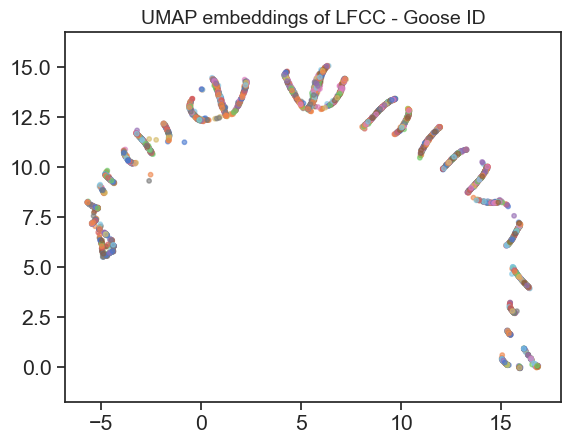

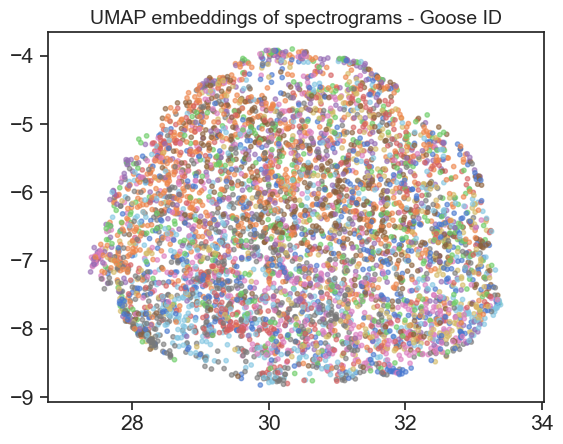

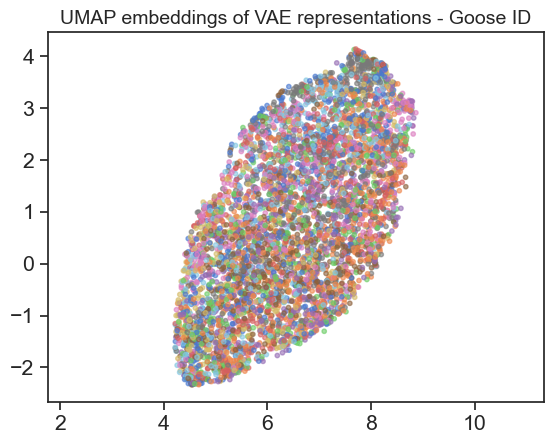

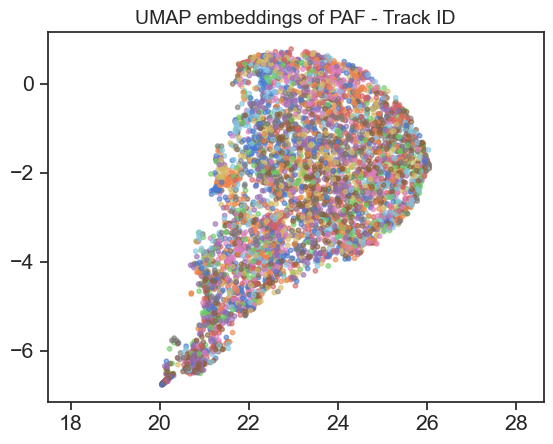

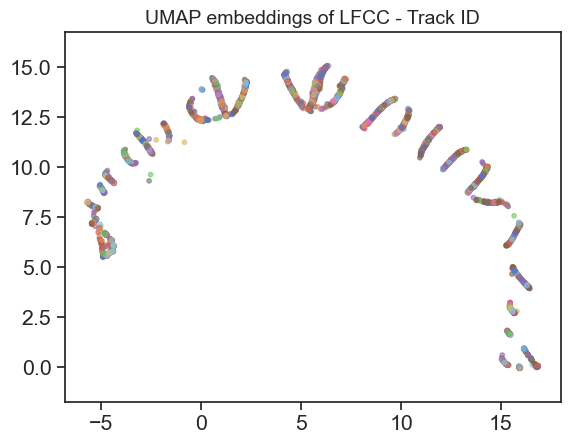

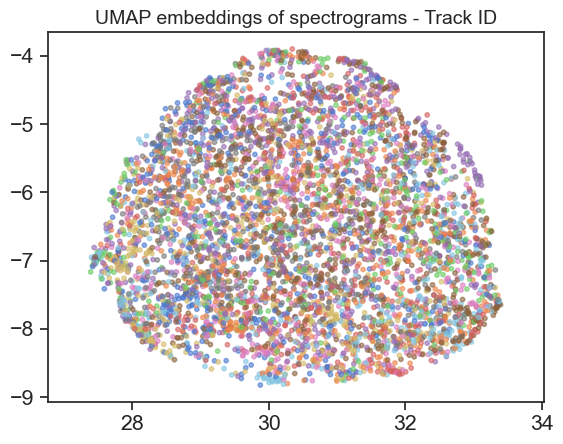

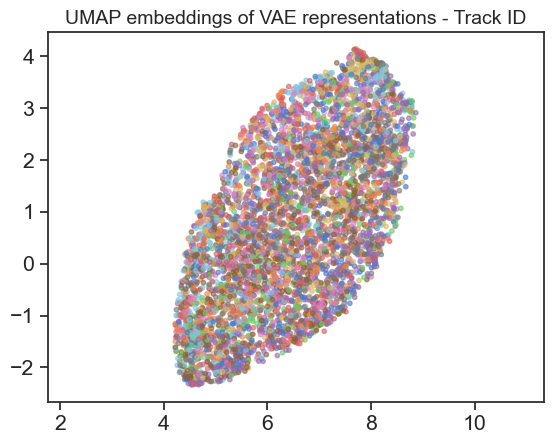

In [35]:
n_neighbors = int(len(filtered_calls_df_contact_rec) * NEIGHBORS_RATIO)

# Load representation dataframes
paf_scaled_contact = StandardScaler().fit_transform(filtered_calls_df_contact_rec.drop(columns=[col for col in filtered_calls_df_contact_rec.columns if col not in feature_columns_list])) #["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_scaled_spectrogram", "log_padded_spectrogram", "log_padded_lfccs", "log_padded_log_freq_spectrogram", "lfccs", "log_padded_lfccs", "latent_representation", "duration_paf"]
lfccs_scaled_contact, lfccs_df_contact = create_representations_subdf_and_scale(filtered_calls_df_contact_rec, "log_padded_lfccs")
spectrograms_scaled_contact, spectrograms_df_contact = create_representations_subdf_and_scale(filtered_calls_df_contact_rec, "log_padded_spectrogram")
_, vae_df_contact = create_representations_subdf_and_scale(filtered_calls_df_contact_rec, "latent_representation")

# NN Graphs
nn_results_paf_contact = nearest_neighbors(paf_scaled_contact, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_lfcc_contact = nearest_neighbors(lfccs_scaled_contact, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_spec_contact = nearest_neighbors(spectrograms_scaled_contact, n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)
nn_results_vae_contact = nearest_neighbors(vae_df_contact.drop(columns=["call_type", "track_ID", "goose_ID"]), n_neighbors=n_neighbors, metric=DISTANCE_METRIC, metric_kwds={}, angular=False, random_state=RANDOM_SEED, verbose=False)

# Reduce dimensionality
embeddings_paf_contact = umap.UMAP(precomputed_knn=nn_results_paf_contact, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(paf_scaled_contact)
embeddings_lfcc_contact = umap.UMAP(precomputed_knn=nn_results_lfcc_contact, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(lfccs_scaled_contact)
embeddings_spec_contact = umap.UMAP(precomputed_knn=nn_results_spec_contact, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(spectrograms_scaled_contact)
embeddings_vae_contact = umap.UMAP(precomputed_knn=nn_results_vae_contact, n_neighbors=n_neighbors, n_components=2, min_dist=0, random_state=RANDOM_SEED, n_jobs=1).fit_transform(vae_df_contact.drop(columns=["call_type", "track_ID", "goose_ID"]))

plot_all(filtered_calls_df_contact_rec, embeddings_paf_contact, embeddings_lfcc_contact, embeddings_spec_contact, embeddings_vae_contact)